# Network Intrusion Detection using XGBoost

This notebook builds and evaluates a machine learning–based intrusion detection system
using the NSL-KDD dataset, focusing on recall optimization and threshold tuning.

In [1]:
!pip install xgboost

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import ConfusionMatrixDisplay
import plotly.graph_objects as go
from sklearn.metrics import precision_recall_curve, precision_score, recall_score

## Data Loading

In [4]:
columns = [
    'duration','protocol_type','service','flag','src_bytes','dst_bytes',
    'land','wrong_fragment','urgent','hot','num_failed_logins',
    'logged_in','num_compromised','root_shell','su_attempted',
    'num_root','num_file_creations','num_shells','num_access_files',
    'num_outbound_cmds','is_host_login','is_guest_login','count',
    'srv_count','serror_rate','srv_serror_rate','rerror_rate',
    'srv_rerror_rate','same_srv_rate','diff_srv_rate',
    'srv_diff_host_rate','dst_host_count','dst_host_srv_count',
    'dst_host_same_srv_rate','dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate',
    'dst_host_serror_rate','dst_host_srv_serror_rate',
    'dst_host_rerror_rate','dst_host_srv_rerror_rate',
    'label','difficulty'
]

df = pd.read_csv("/content/KDDTrain+.txt", names=columns)

df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


## Preprocessing

In [5]:
print("Dataset shape:", df.shape)
df['label'].value_counts().head(10)

Dataset shape: (125973, 43)


,count
label,
normal,67343
neptune,41214
satan,3633
ipsweep,3599
portsweep,2931
smurf,2646
nmap,1493
back,956
teardrop,892


In [6]:
df['binary_label'] = df['label'].apply(lambda x: 0 if x == 'normal' else 1)
df['binary_label'].value_counts()

,count
binary_label,
0,67343
1,58630


In [7]:
cat_cols = ['protocol_type', 'service', 'flag']
encoder = LabelEncoder()
for col in cat_cols:
    df[col] = encoder.fit_transform(df[col])
df[cat_cols].head()

,protocol_type,service,flag
0,1,20,9
1,2,44,9
2,1,49,5
3,1,24,9
4,1,24,9


In [8]:
X = df.drop(['label', 'binary_label', 'difficulty'], axis=1)
y = df['binary_label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (100778, 41)
Test size: (25195, 41)


## Exploratory Data Analysis

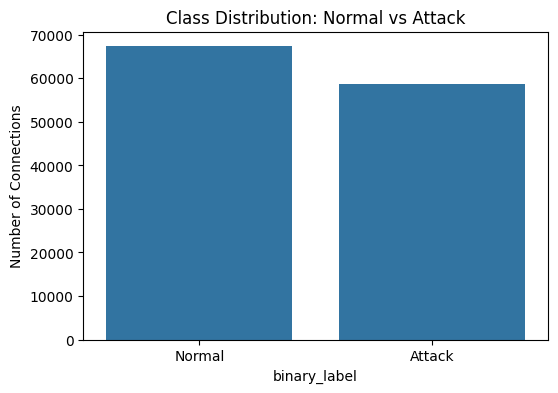

In [9]:
plt.figure(figsize=(6,4))
sns.countplot(x=df['binary_label'])
plt.xticks([0,1], ['Normal', 'Attack'])
plt.title("Class Distribution: Normal vs Attack")
plt.ylabel("Number of Connections")
plt.show()

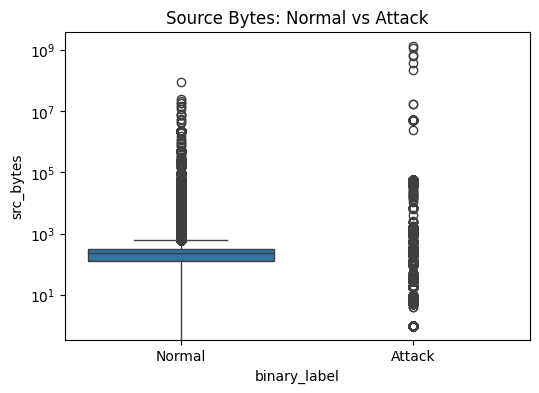

In [10]:
plt.figure(figsize=(6,4))
sns.boxplot(x='binary_label', y='src_bytes', data=df)
plt.xticks([0,1], ['Normal', 'Attack'])
plt.yscale('log')
plt.title("Source Bytes: Normal vs Attack")
plt.show()


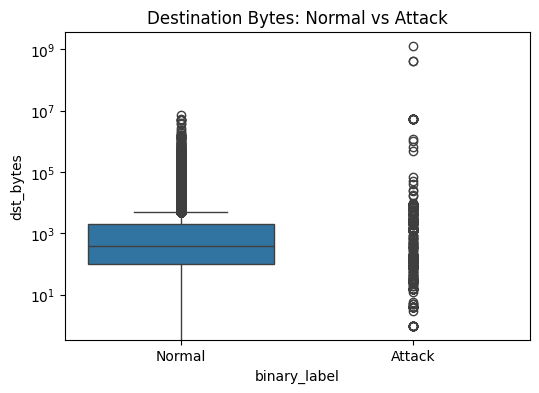

In [11]:
plt.figure(figsize=(6,4))
sns.boxplot(x='binary_label', y='dst_bytes', data=df)
plt.xticks([0,1], ['Normal', 'Attack'])
plt.yscale('log')
plt.title("Destination Bytes: Normal vs Attack")
plt.show()


Attacks have:

1) Very low bytes (scans)

2) Or extreme spikes (DoS)

Normal traffic is more balanced

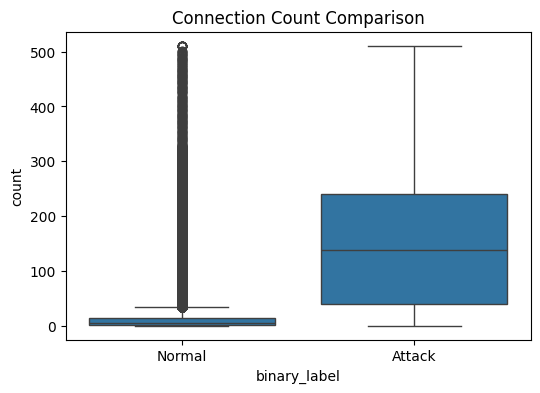

In [12]:
plt.figure(figsize=(6,4))
sns.boxplot(x='binary_label', y='count', data=df)
plt.xticks([0,1], ['Normal', 'Attack'])
plt.title("Connection Count Comparison")
plt.show()

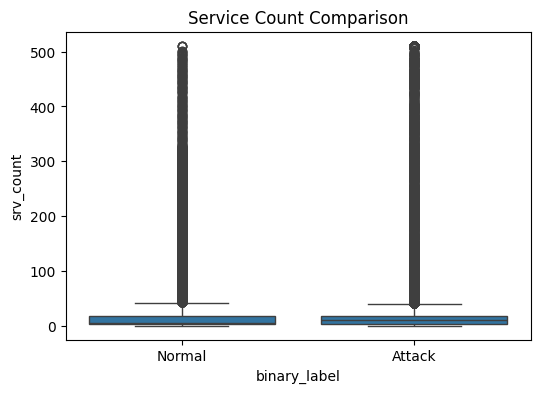

In [13]:
plt.figure(figsize=(6,4))
sns.boxplot(x='binary_label', y='srv_count', data=df)
plt.xticks([0,1], ['Normal', 'Attack'])
plt.title("Service Count Comparison")
plt.show()

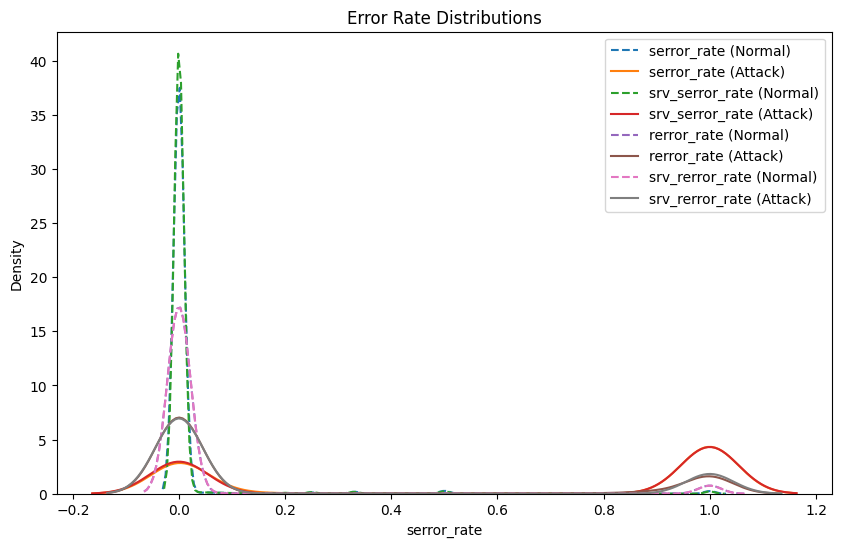

In [14]:
error_features = [
    'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate'
]

plt.figure(figsize=(10,6))
for feat in error_features:
    sns.kdeplot(
        df[df['binary_label']==0][feat],
        label=f"{feat} (Normal)",
        linestyle="--"
    )
    sns.kdeplot(
        df[df['binary_label']==1][feat],
        label=f"{feat} (Attack)"
    )

plt.title("Error Rate Distributions")
plt.legend()
plt.show()


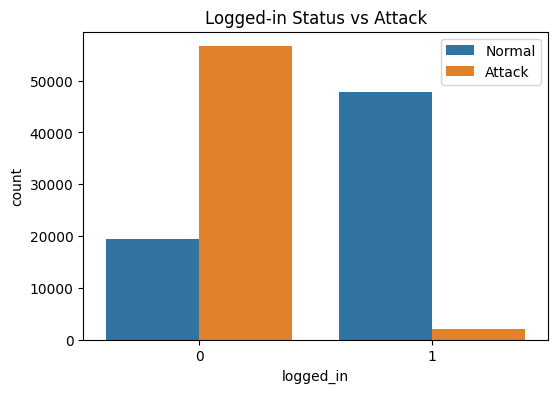

In [15]:
plt.figure(figsize=(6,4))
sns.countplot(x='logged_in', hue='binary_label', data=df)
plt.title("Logged-in Status vs Attack")
plt.legend(['Normal','Attack'])
plt.show()


In [16]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()

scale_pos_weight = neg / pos
scale_pos_weight

np.float64(1.1486013986013985)

In [17]:
xgb_model = XGBClassifier(
    objective='binary:logistic',
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [18]:
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13469
           1       1.00      1.00      1.00     11726

    accuracy                           1.00     25195
   macro avg       1.00      1.00      1.00     25195
weighted avg       1.00      1.00      1.00     25195



In [20]:
xgb_no_weight = XGBClassifier(eval_metric='logloss')
xgb_no_weight.fit(X_train, y_train)

print("WITHOUT scale_pos_weight")
print(classification_report(y_test, xgb_no_weight.predict(X_test)))

print("\nWITH scale_pos_weight")
print(classification_report(y_test, y_pred))

WITHOUT scale_pos_weight
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13469
           1       1.00      1.00      1.00     11726

    accuracy                           1.00     25195
   macro avg       1.00      1.00      1.00     25195
weighted avg       1.00      1.00      1.00     25195


WITH scale_pos_weight
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13469
           1       1.00      1.00      1.00     11726

    accuracy                           1.00     25195
   macro avg       1.00      1.00      1.00     25195
weighted avg       1.00      1.00      1.00     25195



Here model overfitted!!
Lets check on test dataset...

In [25]:
df = pd.read_csv("KDDTrain+.txt", names=columns)
df['binary_label'] = df['label'].apply(
    lambda x: 0 if x == 'normal' else 1
)

In [26]:
cat_cols = ['protocol_type', 'service', 'flag']
encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])   # FIT here
    encoders[col] = le


In [27]:
df_test = pd.read_csv("KDDTest+.txt", names=columns)

df_test['binary_label'] = df_test['label'].apply(
    lambda x: 0 if x == 'normal' else 1
)

for col in cat_cols:
    df_test[col] = encoders[col].transform(df_test[col])

In [28]:
X_test_real = df_test.drop(['label', 'binary_label', 'difficulty'], axis=1)
y_test_real = df_test['binary_label']

print(X_test_real.shape)
print(y_test_real.value_counts())


(22544, 41)
binary_label
1    12833
0     9711
Name: count, dtype: int64


In [32]:
y_pred_no_weight = xgb_no_weight.predict(X_test_real)

print("WITHOUT scale_pos_weight — KDDTest+")
print(classification_report(y_test_real, y_pred_no_weight))
y_pred_weighted = xgb_model.predict(X_test_real)

print("\n WITH scale_pos_weight — KDDTest+")
print(classification_report(y_test_real, y_pred_weighted))


WITHOUT scale_pos_weight — KDDTest+
              precision    recall  f1-score   support

           0       0.69      0.97      0.81      9711
           1       0.97      0.67      0.79     12833

    accuracy                           0.80     22544
   macro avg       0.83      0.82      0.80     22544
weighted avg       0.85      0.80      0.80     22544


 WITH scale_pos_weight — KDDTest+
              precision    recall  f1-score   support

           0       0.70      0.97      0.81      9711
           1       0.97      0.68      0.80     12833

    accuracy                           0.80     22544
   macro avg       0.83      0.82      0.80     22544
weighted avg       0.85      0.80      0.80     22544



In [33]:
# Probabilities for class = 1 (Attack)
y_prob = xgb_model.predict_proba(X_test_real)[:, 1]
y_prob[:10]

array([9.9996722e-01, 9.9993300e-01, 1.2711496e-03, 9.9683374e-01,
       9.1409765e-02, 1.7378334e-05, 4.5108525e-03, 4.9073156e-04,
       9.1051361e-06, 9.5887861e-04], dtype=float32)

In [34]:
thresholds = [0.5, 0.4, 0.3, 0.2, 0.1]

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    print(f"\n🔹 Threshold = {t}")
    print(classification_report(y_test_real, y_pred_t))


🔹 Threshold = 0.5
              precision    recall  f1-score   support

           0       0.70      0.97      0.81      9711
           1       0.97      0.68      0.80     12833

    accuracy                           0.80     22544
   macro avg       0.83      0.82      0.80     22544
weighted avg       0.85      0.80      0.80     22544


🔹 Threshold = 0.4
              precision    recall  f1-score   support

           0       0.70      0.97      0.81      9711
           1       0.97      0.68      0.80     12833

    accuracy                           0.81     22544
   macro avg       0.83      0.83      0.81     22544
weighted avg       0.85      0.81      0.81     22544


🔹 Threshold = 0.3
              precision    recall  f1-score   support

           0       0.71      0.97      0.82      9711
           1       0.97      0.70      0.81     12833

    accuracy                           0.81     22544
   macro avg       0.84      0.83      0.81     22544
weighted avg     

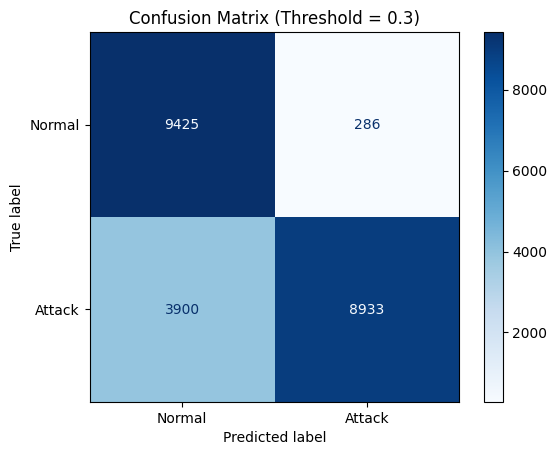

In [36]:

t = 0.3
y_pred_final = (y_prob >= t).astype(int)

ConfusionMatrixDisplay.from_predictions(
    y_test_real,
    y_pred_final,
    display_labels=["Normal", "Attack"],
    cmap="Blues"
)

plt.title(f"Confusion Matrix (Threshold = {t})")
plt.show()

We should use Threshold = 0.2
Why?

Recall ≈ 0.71

Precision ≈ 0.97

Very few false alarms

Strong security posture

In [38]:
precision, recall, thresholds = precision_recall_curve(
    y_test_real,
    y_prob
)

ap = average_precision_score(y_test_real, y_prob)
ap

np.float64(0.9739424928238603)

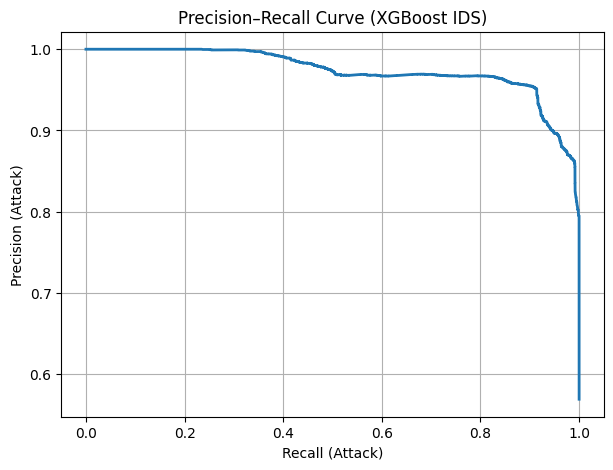

In [39]:
plt.figure(figsize=(7,5))
plt.plot(recall, precision, linewidth=2)
plt.xlabel("Recall (Attack)")
plt.ylabel("Precision (Attack)")
plt.title("Precision–Recall Curve (XGBoost IDS)")
plt.grid(True)
plt.show()

Lowering the decision threshold increases attack recall with minimal loss in precision.
A threshold of 0.2 provides the best tradeoff for IDS deployment.


In [44]:
precision, recall, _ = precision_recall_curve(y_test_real, y_prob)
check_thresholds = [0.5, 0.4, 0.3, 0.2, 0.1]
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=recall,
    y=precision,
    mode="lines",
    name="PR Curve"
))

for t in check_thresholds:
    y_pred_t = (y_prob >= t).astype(int)

    p = precision_score(y_test_real, y_pred_t)
    r = recall_score(y_test_real, y_pred_t)

    fig.add_trace(go.Scatter(
        x=[r],
        y=[p],
        mode="markers",
        marker=dict(size=12),
        name=f"Threshold {t}",
        hovertemplate=
        f"<b>Threshold:</b> {t}<br>"
        f"<b>Recall:</b> {r:.3f}<br>"
        f"<b>Precision:</b> {p:.3f}<extra></extra>"
    ))

fig.update_layout(
    title="Precision–Recall Curve with Interactive Thresholds",
    xaxis_title="Recall (Attack)",
    yaxis_title="Precision (Attack)",
    hovermode="closest"
)

fig.show()


I selected the decision threshold using a Precision–Recall curve rather than accuracy, identifying an operating point that maximized attack recall while maintaining high precision, which is critical for intrusion detection systems.

In [41]:
FINAL_THRESHOLD = 0.2
y_pred_final = (y_prob >= FINAL_THRESHOLD).astype(int)

print(classification_report(y_test_real, y_pred_final))

              precision    recall  f1-score   support

           0       0.71      0.97      0.82      9711
           1       0.97      0.71      0.82     12833

    accuracy                           0.82     22544
   macro avg       0.84      0.84      0.82     22544
weighted avg       0.86      0.82      0.82     22544



## Conclusion

This project demonstrates how XGBoost can be used for network intrusion detection
on tabular data. While training accuracy was high, evaluation on unseen attack data
highlighted the importance of threshold tuning and precision–recall tradeoffs.
The final system prioritizes attack recall while maintaining high precision,
making it suitable for real-world IDS scenarios.
